# Assignment 1

You are expected to complete this notebook with lines of code, plots and texts. Sometimes you will make modifications to existing cells and sometimes you may need to create new cells with original code or text for your analyses. This assignment has a total of 100 points.

 
These are the kinds of questions you will have:
- Questions that require only modification of code will be marked with a **C**
- Theoretical questions that require only text or mathematical equations to answer will be marked with a **T**. When an equation is asked, you can write it in python/numpy syntax (enclose it using \`\`) or in latex syntax (enclose it using \$\$).
- Questions that require an analysis of results that may include text, code and visualizations will be marked with an **A**. The first questions of this type will be more explicit of what you should write. They will become more open-ended as the assignment goes on.

Using Canvas, you will deliver the notebook file (.ipynb) with cells executed and outputs visible.

- No other packages than the ones already imported can be used.
- No other data than the variables provided should be used.
- The cell outputs present in your delivered notebook should be reproducible by us by running your notebook cells in order.
- Your final delivery should not have modified current code outside of these demarcations, but, if needed for testing, feel free to modify it and later reverse to its original state.
- All code must be your own work. Code cannot be copied from another source or student. You may copy code from cells that were pre-defined in this notebook if you think it is useful for use in another question.
- All images must be generated from data generated in your code. Do NOT import/display images generated outside your code.
- Your analysis must be your own, but if you quote text or equations from another source make sure to cite the reference.

Other notes:
- Cells should be run in order, using Shift+Enter.
- Read all the provided code cells and its comments, as it contains variables and information that you may need to use to complete the notebook.
- Existing cells that require your input with code will be marked with comments `##your code starts here` and `##your code ends here` to specify where you need to write code.
- Ends of questions are marked with **END**, to try to make it clearer where your modifications to the notebook should be provided. 
- To create a text cell, create it with the "+" button and change its type from "Code" to "Markdown" using the upper menu. To modify a text cell, double click on it.
- If you are interested, you can check detail on formatting markdown text here: https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed
- A python/numpy/matplotlib tutorial that you might find useful: http://cs231n.github.io/python-numpy-tutorial/

Setting libraries and useful functions:

In [7]:
#install a few libraries that will be used
!pip3 install matplotlib
!pip3 install numpy
!pip3 install pandas
!pip3 install python-mnist

#import a few libraries. Numpy is named as np and pyplot in matplotlib as plt
import urllib.request
import pandas
import numpy as np
import matplotlib.pyplot as plt
import copy
from utils import test_gradient, preprocess_medical_data, load_and_preprocess_mnist

#needed to plot plots with matplotlib in OSX
%matplotlib inline

#set numpy to raise exceptions when encountering numerical errors
np.seterr(all='raise')

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

In [8]:
#this function is used to convert from integer encoding of labels to one hot encoding
# labels is an 1-D array with the integer labels from 0 to n_labels. 
def one_hot(labels, n_labels):
    return np.squeeze(np.eye(n_labels)[labels.reshape(-1)])

#Does the transpose of the last two axes of a tensor
def T(input_tensor):
    return np.swapaxes(input_tensor, -1, -2)

## Exercise 1: Analyzing model capacity in a polynomial toy example
**(Total of 26 points)**

This exercise will illustrate how validation error of a model evolves by changing model capacity. We are going to start with a simple example of generated data that follows a third degree polynomial.

**C 1.1 (3 points)**: Write the body of the function `third_degree_polynomial` that returns the output of a third degree polynomial. The function receives two numpy arrays, `x` and `constants_vector`. `x` will have the shape [batch, 1] and `constants_vector` [4,1]. If `constants_vector` is $[a_0, a_1, a_2, a_3]$, the function should return, for each of the batch examples indexed by i, $a_3\times x_i^3 + a_2\times x_i^2 + a_1\times x_i + a_0$. The shape of the returned array should be [batch, 1].

In [9]:
def third_degree_polynomial(x, constants_vector):
    x_2 = np.multiply(x, x);
    x_3 = np.multiply(x_2, x);
    return constants_vector[0] + np.multiply(constants_vector[1], x) + np.multiply(constants_vector[2], x_2) + np.multiply(constants_vector[3], x_3)


In [10]:
#test your function to make sure it is doing what is expected
predicted_values = third_degree_polynomial(np.expand_dims(np.arange(0,2,0.1), axis = 1), np.expand_dims(np.array([5.3,2.4,0.52,1.32]), axis = 1))
if np.allclose(predicted_values, np.array([[5.3], [5.54652], [5.81136], [6.10244], [6.42768], [6.795], [ 7.21232], [ 7.68756], [ 8.22864], [ 8.84348], [ 9.54], [10.32612], [11.20976], [12.19884], [13.30128], [14.525], [15.87792], [17.36796], [19.00304], [20.79108]])):
    print('Your third_degree_polynomial function seems to be returning the expected values')
else:
    print('WARNING: Your third_degree_polynomial function is not returning the expected values. You should review your code.')

Your third_degree_polynomial function seems to be returning the expected values


**END C 1.1**

Setting data for Exercise 1 and 2. Pay attention to the names of the variables because you are going to need to use them in parts of your code.

In [11]:
#Generating input data and target data for this exercise
#noise is added to data to make the fitting inexact

#Training data input you are going to use for exercises 1 and 2
x_ex1_train = np.expand_dims(np.arange(0,2,0.1), axis = 1)

#coefficients of the third degree polynomial used to generate the data
coefficients_ex1 = np.array([[1,-2,3,-1]]).T

y_ex1_train = third_degree_polynomial(x_ex1_train, coefficients_ex1) 

#Testing data you are going to use for exercises 1 and 2
x_ex1_val = np.expand_dims(np.arange(0,2,0.01), axis = 1)
y_ex1_val = third_degree_polynomial(x_ex1_val,coefficients_ex1) 

#add noise to it
np.random.seed(1)
y_ex1_train = y_ex1_train + 0.2 * np.random.normal(size = x_ex1_train.shape)
y_ex1_val = y_ex1_val + 0.2 * np.random.normal(size = x_ex1_val.shape)

Plotting the generated data to visualize what we just generated for this exercise:

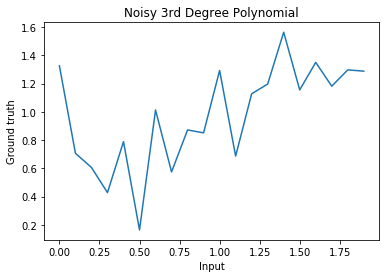

In [12]:
#plotting the data we just generated as a sanity check
plt.plot(x_ex1_train, y_ex1_train);
plt.title('Noisy 3rd Degree Polynomial');
plt.xlabel('Input');
plt.ylabel('Ground truth');

In this exercise, we are going to fit polynomial functions to this data that we just generated. Since we are going to be using polynomials, we can use a closed solution fitting function. 

**C 1.2 (3 points)**: Write the remaining body of the function `fit`, that receives the degree of the polynomial to fit (an integer), and input and target arrays (both of shape [batch, 1]) and that returns the coefficients of that polynomial (of shape [degree, 1]) with the least mean square error for the provided data (polynomial least square fit). The only part left for you to complete is the building of the Design Matrix `X`.

In [13]:
def fit(degree, inputs, targets):
    ##your code starts here
    
    ##your code ends here
    return np.linalg.inv(X.T@X)@X.T@targets

In [14]:
#test your function to make sure it is doing what is expected
weights_ex1_train = fit(5,x_ex1_train,y_ex1_train)
if np.allclose(weights_ex1_train, np.array([[  1.2574006 ], [ -5.50854483], [ 13.21760281], [-12.60429544], [  5.62135688], [ -0.97197598]])):
    print('Your fitting function seems to be returning the expected values')
else:
    print('WARNING: Your fitting function is not returning the expected values. You should review your code.')

NameError: name 'X' is not defined

**END C 1.2**

**C 1.3 (4 points)**: Since we are going to have coefficients for polynomials of different degrees, we should also be able to get their evaluated values for different inputs. Write the body of the `any_degree_polynomial` function, which receives two numpy arrays, `x` and `constants_vector`. `x` will have the shape [batch, 1] and `constants_vector` [degree,1]. If `constants_vector` is $[a_0, a_1, a_2]$, for example, the function should return, for each of the batch examples indexed by i, $a_2\times x_i^2 + a_1\times x_i + a_0$. The shape of the returned array should be [batch, 1].

In [ ]:
def any_degree_polynomial(x, constants_vector):
    ##your code starts here
    
    ##your code ends here

**END C 1.3**

**C 1.4 (3 points)**: Fit a third degree polynomial to the provided data and plot, in the same graph, your fitted results and the training data. Use a legend to identify what each curve is.

In [ ]:
#Fit a 3rd degree polynomial to data and visualize the result of your fit
##your code starts here

##your code starts here

**END C 1.4**

We are now going to evaluate how polynomials of different degrees perform in the validation data when fitted to the training data. 

**C 1.5 (3 points)**: First we are going to define the function that returns the metric used to evaluate the results. Complete the body of the `mse` function. The function receives two arrays of same shape, [batch, 1], and returns the mean square error, defined by  $\frac{1}{N}\sum{\left( \hat{y} - y \right)^{2}}$, between them. The returned value should be a float variable.

In [ ]:
def mse(predicted_values, targets):
    ##your code starts here
    
    ##your code ends here

In [ ]:
#test your function to make sure it is doing what is expected
mse_testing_function = mse(y_ex1_val[:20,:],y_ex1_train)
if np.allclose(np.array([mse_testing_function]), np.array([0.23499996035092258])):
    print('Your error function seems to be returning the expected values')
else:
    print('WARNING: Your error function is not returning the expected values. You should review your code.')

**END C 1.5**

**A 1.6 (10 points)**: We are going to treat the degree of the fitting polynomial as the hyperparameter of our model. Fit polynomials of degrees from 1 to 10, plot the mean square error for each different degree using, in separate curves but same graph, both the training data and the validation data. Write a short analysis of the results presented in your plot, stating which degrees are overfitting and which are underfitting, and why.

In [ ]:
##your code starts here

##your code ends here

**END A 1.6**

## Exercise 2: Defining and training fully connected networks
**(Total of 31 points)**

In this exercise, we are going to define functions to train a fully connected network with one hidden layer. First, we set a function to initialize the learnable parameters of the network. They are going to be bidimensional arrays stored in a python dictionary, where the keys of the dictionary represent the name of the parameters of the network. The parameters are called 'weights_i' and 'bias_i' where i is the layer where the parameter is used. Instead of using the equation $W^Tx+b$ for linear layers as seen in class, use $vW+b$, $v$ being a row-vector. We do so for practical reasons of facilitating batch vector-matrix multiplication in numpy.

In [ ]:
def initialize_parameters_ex2(n_inputs, n_hidden_nodes, n_outputs):
    np.random.seed(1)
    #initialize weights centered in 0
    weights_1 = np.random.normal(0,0.5,[n_inputs,n_hidden_nodes])
    # initialize bias with a small positive value to reduce amount of dead neurons
    bias_1 = np.random.normal(0.1,0,[n_hidden_nodes])
    #initialize weights centered in 0
    weights_2 = np.random.normal(0,0.5,[n_hidden_nodes,n_outputs])
    # initialize bias with a small positive value to reduce amount of dead neurons
    bias_2 = np.random.normal(0.1,0,[n_outputs])
    return {'weights_1':weights_1, 'weights_2':weights_2, 'bias_1':bias_1, 'bias_2':bias_2}

**C 2.1 (6 points)**: Write the body of the function `two_layer_network_forward` that defines a forward pass of a two-layer fully connected network with ReLU as activation function.

In [ ]:
def two_layer_network_forward(inputs, parameters, return_intermediary_results = False):
    
    ##your code starts here
    out_1 =  #output of the first linear layer before activation function; it should have shape [batch, n_hidden_nodes] 
    out_1_relu =   #output of the first activation function; it should have shape [batch, n_hidden_nodes] 
    out_2 =  #output of the second linear_layer; it should have shape [batch, n_outputs] 
    ##your code ends here
    
    #return_intermediary_results should only be True if you are going to use this forward pass
    # to calculate gradients for the network parameters
    if return_intermediary_results:
        #if you are doing the forward pass to calculate backward pass afterwards, you are going to need all intermediary results
        to_return = {'out_1': out_1, 'out_1_relu': out_1_relu, 'out_2': out_2}
    else:
        #if you are doing the forward pass just to get the output of the network, you only need the final result
        to_return = out_2
    return to_return

In [ ]:
#test your function
predicted_outputs_testing_function = two_layer_network_forward(x_ex1_train, initialize_parameters_ex2(1, 20, 1))
if np.allclose(predicted_outputs_testing_function, np.array([[0.30413895], [0.28105381], [0.21761113], [0.236233  ], [0.27359281], [0.2995363 ], [0.32282194], [0.33807287], [0.35145301], [0.36860323], [0.38583117], [0.40305912], [0.42173721], [0.44258177], [0.46342632], [0.48427088], [0.50511543], [0.52595998], [0.54680454], [0.56764909]])):    
    print('Your forward function seems to be returning the expected values')
else:
    print('WARNING: Your forward function is not returning the expected values. You should review your code.')

**END C 2.1**

**T 2.2 (3 points)**: Calculate how many parameters a network initialized with initialize_parameters_ex2 would have, as a function of n_inputs, n_hidden_nodes and n_outputs.

**Put your final answer here:** 

**END T 2.2**

**C 2.3 (14 points)**: Fill in the code for each of the required derivatives. 

Tips: for one input example, if $L=f(y)$ and $y = vW+b$, 

$$\frac{\partial L}{\partial W}  = \frac{\partial L}{\partial y}\frac{\partial y}{\partial W}  = v^T\frac{\partial L}{\partial y}$$ 

$$\frac{\partial L}{\partial v}  = \frac{\partial L}{\partial y}\frac{\partial y}{\partial v}  = \frac{\partial L}{\partial y}W^T$$ 

$$\frac{\partial L}{\partial b}=\frac{\partial L}{\partial y}\frac{\partial y}{\partial b}  = \frac{\partial L}{\partial y}$$ 

$L$ being a scalar, $v$ a row-vector, $W$ a matrix and $b$ a row-vector.

In [ ]:
def mse_loss_backward(predicted, gt):
    ##your code starts here
    derivative_of_mse_loss_with_respect_to_predicted =  #d(loss)/d(predicted); it should have shape [batch, n_outputs] 
    ##your code ends here
    return derivative_of_mse_loss_with_respect_to_predicted

def two_layer_network_backward(inputs, parameters, gt, loss_backward):
    
    intermediary_results_in_forward = two_layer_network_forward(inputs, parameters, return_intermediary_results = True)

    out_1 = intermediary_results_in_forward['out_1'] 
    out_1_relu = intermediary_results_in_forward['out_1_relu'] 
    out_2 = intermediary_results_in_forward['out_2'] 
    
    derivative_of_loss_with_respect_to_out_2 =  loss_backward(out_2, gt) 
    
    ##your code starts here
    
    derivative_of_loss_with_respect_to_bias_2 =  #d(loss)/d(bias_2); it should have shape [batch, n_outputs] 
    derivative_of_loss_with_respect_to_weights_2 =  #d(loss)/d(weights_2); it should have shape [batch, n_hidden_nodes, n_outputs] 
    derivative_of_loss_with_respect_to_out_1_relu =  #d(loss)/d(out_1_relu); it should have shape [batch, n_hidden_nodes] 
    derivative_of_loss_with_respect_to_out_1 =  #d(loss)/d(out_1); it should have shape [batch, n_hidden_nodes] 
    derivative_of_loss_with_respect_to_bias_1 =  #d(loss)/d(bias_1); it should have shape [batch, n_hidden_nodes] 
    derivative_of_loss_with_respect_to_weights_1 =  #d(loss)/d(weights_1); it should have shape [batch, n_inputs, n_hidden_nodes] 
    
    ##your code ends here
    
    return {
            'weights_1': np.mean(derivative_of_loss_with_respect_to_weights_1, axis = 0),
            'bias_1': np.mean(derivative_of_loss_with_respect_to_bias_1, axis = 0), 
            'weights_2':np.mean(derivative_of_loss_with_respect_to_weights_2, axis = 0) , 
            'bias_2':np.mean(derivative_of_loss_with_respect_to_bias_2, axis = 0)
            }

def two_layer_network_mse_backward(inputs, parameters, gt):
    return two_layer_network_backward(inputs, parameters, gt, mse_loss_backward)

In [ ]:
test_gradient(two_layer_network_forward, two_layer_network_mse_backward, mse, x_ex1_train[0:20,:], y_ex1_train[0:20,:], initialize_parameters_ex2(1, 10, 1) )

**END C 2.3**

**C 2.4 (8 points)** Write the update rule for a batch of training. Your function `run_batch_sgd` should calculate the gradients and update the parameters using the vanilla stochastic gradient descent update rule. You should also implement the use of this function for each batch in the second block of your code and the plot of the results in the last block of your code.

In [ ]:
def run_batch_sgd(backward_function, parameters, learning_rate, inputs, targets):
    #calculate gradients and update parameters using sgd update rule
    ##your code starts here
    
    ##your code ends here
    return updated_parameters

n_hidden_nodes = 50
parameters_two_layer_regression = initialize_parameters_ex2(1, n_hidden_nodes, 1)

learning_rate = 0.001
batch_size = 20
n_epochs = 1000

for epoch in range(n_epochs):
    shuffled_indexes = (np.arange(x_ex1_train.shape[0]))
    np.random.shuffle(shuffled_indexes)
    shuffled_indexes = shuffled_indexes.reshape([-1, batch_size])
    for batch_i in range(shuffled_indexes.shape[1]):    
        batch = shuffled_indexes[:,batch_i]
        input_this_batch = x_ex1_train[batch,:]
        gt_this_batch =  y_ex1_train[batch,:]
        #use you function run_batch_sgd to update the parameters
        ##your code starts here
        
        ##your code ends here

#plot the results of training
##your code starts here

##your code ends here

**END C 2.4**

## Exercise 3: Medical Dataset - Classification task with cross-entropy and softmax
**(Total of 19 points)**

In this exercise we are going to complement what was defined in Exercise 2, to make it compatible with classification tasks, and analyze hyperparameters. The dataset we are going to use here is a medical dataset, available at https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition, that contains preprocessed 1-D signals of EEGs and a label specifying if the patient was having a seizure during the recording or not.

Loading, preprocessing and checking the data:

In [ ]:
#download the dataset
urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/00388/data.csv', './data_ex3.csv')
#read the csv file
data_ex3 = pandas.read_csv('./data_ex3.csv')
#modify labels since we are going to do a binary classification, seizure or no seizure, 
# and presence of seizure is represented by label 1
data_ex3.y = data_ex3.y.map({1:1,2:0,3:0,4:0,5:0})

In [ ]:
#visualizing the current table of the loaded dataset to see how it is organized
data_ex3[:5]

In [ ]:
# preprocess the data you just loaded
train_data_ex3, val_data_ex3, test_data_ex3, train_labels_ex3, val_labels_ex3, test_labels_ex3 =  preprocess_medical_data(data_ex3)

In [ ]:
#sanity check of the result of normalization, one-hot encoding and shapes of the data vectors
print('train_data_ex3:\n ' + str(train_data_ex3))
print('train_labels_ex3:\n ' + str(train_labels_ex3))
print('train_data_ex3.shape: ' + str(train_data_ex3.shape))
print('train_labels_ex3.shape: ' + str(train_labels_ex3.shape))
print('val_data_ex3.shape: ' + str(val_data_ex3.shape))
print('val_labels_ex3.shape: ' + str(val_labels_ex3.shape))
print('test_data_ex3.shape: ' + str(test_data_ex3.shape))
print('test_labels_ex3.shape: ' + str(test_labels_ex3.shape))

#checking how many of the labels are seizure labels
#the dataset is unbalanced, but you should use it just like that
print('Percentage of examples containing seizures: ' + str(np.sum(train_labels_ex3[:,1])/float(len(train_labels_ex3))*100) + '%')


Defining a few functions that we will be using in this exercise:

In [ ]:
#a softmax calculation with numerical stability tricks
def softmax(logits, axis):
    # subtracting the maximum logit from all logits for each example and prevents overflow 
    # of the exponential function of the logits and does not change results of the softmax
    # because of properties of division of exponentials
    stabilizing_logits = logits - np.expand_dims(np.max(logits, axis = axis), axis = axis)
    
    # clipping all logits to a minimum of -10 prevents underflow of the exponentials and 
    # only changes the result of the softmax minimally, since we know that one logit has value 0
    # and exp^0>>exp(-10)
    stabilizing_logits = np.clip(stabilizing_logits, -10, None)
    
    #using the softmax classic equation, but with the modified logits to prevent numerical errors
    return np.exp(stabilizing_logits)/np.expand_dims(np.sum(np.exp(stabilizing_logits), axis = axis), axis = axis)

# a forward function combined the two-layer network and the softmax
def two_layer_network_softmax_forward(inputs, parameters):
    logits = two_layer_network_forward(inputs, parameters)
    return softmax(logits, axis = 1)

# a forward function combined the two-layer network and the softmax
def softmax_plus_ce_loss_backward(predicted, gt):
    #the derivative of the output of softmax function followed by a cross-entropy loss
    # with respect to the input is a beautifully simple equation equals to the softmax
    # of the inputs minus the one-hot encoded groundtruth
    return (softmax(predicted, axis = 1) - gt)

#the calculation of the gradient for the classification network
def two_layer_network_softmax_ce_backward(inputs, parameters, gt):
    return two_layer_network_backward(inputs, parameters, gt, softmax_plus_ce_loss_backward)

# a function to get how many logits predicted the right class when compared to gt
def count_correct_predictions(logits, gt):
    predicted_labels = one_hot(np.argmax(logits, axis = 1), logits.shape[1])
    return np.sum(np.logical_and(predicted_labels,gt))

**C 3.1 (3 points)**: Write the body of the cross-entropy loss for a network output of any bidimensional shape and a one-hot encoded target of same shape.

In [ ]:
def ce_loss(out, target):
    ##your code starts here
    
    ##your code ends here

In [ ]:
#test your function
np.random.seed(1)
ce_loss_testing_function = ce_loss(softmax(np.random.normal(0, 0.5, [12, 13]) + 3*one_hot(np.random.randint(13, size = 12), 13), axis = 1), one_hot(np.random.randint(13, size = 12), 13))
if np.allclose(np.array(ce_loss_testing_function), np.array([3.1249936488336])):    
    print('Your loss function seems to be returning the expected values')
else:
    print('Your loss function is not returning the expected values. You should review your code.')
test_gradient(two_layer_network_softmax_forward, two_layer_network_softmax_ce_backward, ce_loss, train_data_ex3[0:10,:], train_labels_ex3[0:10,:], initialize_parameters_ex2(178, 10, 2))

**END C 3.1**

**A 3.2 (13 points)**: Verify and analyze how the accuracy of a trained two-layer network changes as a function of the number of hidden nodes, for the provided dataset for this exercise. Use the provided learning rate, batch size and number of epochs. You should be able to get a validation accuracy higher than 96%. 

Hints:
- Question 2.4 has code that may be useful here. In addition to what the code in question 2.4 is doing, you will need to loop over different numbers of hidden nodes to train different models, and also write inference loops to get the training and the validation accuracy of your model. For the accuracy calculation, you may find the provided `count_correct_predictions` function useful.

In [ ]:
learning_rate = 0.01 
batch_size = 50
n_epochs = 100

##your code starts here

##your code ends here

**END A 3.2**

**C 3.3 (3 points)**: Test your model best model (model with best found hyperparameters) on the test set.

**END C 3.3**

## Exercise 4: MNIST and weight decay
**(Total of 24 points)**

In this exercise, we are going to use a flattened and reduced MNIST dataset to train a two-layer neural network using L2 regularization. First, we load and preprocess the data:

In [ ]:
x_ex4_train, x_ex4_val, x_ex4_test, y_ex4_train, y_ex4_val, y_ex4_test = load_and_preprocess_mnist()

In [ ]:
#sanity check to see that data is as it is supposed to be
plt.imshow(x_ex4_train[1000,:].reshape(28,28), cmap = 'Greys')
print(y_ex4_train[1000])

**C 4.1 (5 points)**: Considering an L2 penalty over all the weights parameters, and no penalty over bias parameters, complete the function below with the gradients of each different kind of parameter. The L2 penalty is defined as the sum of squares of every element of the penalized parameters.

In [ ]:
def l2_regularization_backward(inputs, parameters, gt):
    gradients = {}
    for parameter_name in parameters.keys():
        if 'weights' in parameter_name:
            # complete the equation to calculate the l2 regularization loss gradient for weights
            ##your code starts here
            gradients[parameter_name] = 
            ##your code ends here
        elif 'bias' in parameter_name:
            # complete the equation to calculate the l2 regularization loss gradient for bias.
            # Remember, the L2 regularization loss for bias is 0.
            ##your code starts here
            gradients[parameter_name] = 
            ##your code ends here
    return gradients

def two_layer_network_ce_and_l2_regularization_backward(inputs, parameters, gt, regularization_multiplier):
    gradients = {}
    gradients1 = two_layer_network_softmax_ce_backward(inputs, parameters, gt)
    gradients2 = l2_regularization_backward(inputs, parameters, gt)
    for parameter_name in parameters:
        gradients[parameter_name] = gradients1[parameter_name] + regularization_multiplier * gradients2[parameter_name]
    return gradients


**END C 4.1**

**A 4.2 (16 points)**: Verify and analyze how the L2 regularization to weights changes the results for the provided dataset using a 200-hidden-nodes two-layer neural network. You should play a bit with the learning rate, batch size and number of epochs too, and be able to get more than 90% accuracy on the validation set.

In [ ]:
n_hidden_nodes = 200

##your code starts here

##your code ends here

**END A 4.2**

**C 4.3 (3 points)**: Test your best model using the provided test set.

**END C 4.3**